# Processing Milwaukee Label (~3K labels) 

Building on `2020-03-24-EDA-Size.ipynb`

Goal is to prep a standard CSV that we can update and populate

In [1]:
import pandas as pd
import numpy as np
import os
import s3fs # for reading from S3FileSystem
import json # for working with JSON files 

import matplotlib.pyplot as plt


pd.set_option('max_colwidth', -1)

In [2]:
SAGEMAKER_PATH = r'/home/ec2-user/SageMaker'
SPLIT_PATH = os.path.join(SAGEMAKER_PATH, 'classify-streetview', 'split-train-test')

In [4]:
MINI_PATH = os.path.join(SAGEMAKER_PATH, 'classify-streetview', 'mini-crops')

# Alternative Template - row for ~3K labels x # crops appeared in

* img_id
* heading
* crop_id
* label
* dist_x_left
* dist_x_right
* dist_y_top
* dist_y_bottom

In [5]:
df_labels = pd.read_csv(os.path.join(SPLIT_PATH, 'restructure_single_labels.csv'))
print(df_labels.shape)
df_labels.head()

(2851, 18)


,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes,img_id,present_ramp,missing_ramp,obstacle,surface_prob,no_sidewalk,null,sv_image_x,sv_image_y,sv_image_y_bottom_origin,label_name
0,680_45.jpg,49558,{},3,0,"{""name"":""point"",""cx"":108,""cy"":389}","{""Present Curb Ramp"":""1\n""}",680,True,False,False,False,False,False,108,389,251,Present Curb Ramp
1,680_45.jpg,49558,{},3,1,"{""name"":""point"",""cx"":160,""cy"":389}","{""Present Curb Ramp"":""1""}",680,True,False,False,False,False,False,160,389,251,Present Curb Ramp
2,680_45.jpg,49558,{},3,2,"{""name"":""point"",""cx"":607,""cy"":453}","{""Present Curb Ramp"":""1""}",680,True,False,False,False,False,False,607,453,187,Present Curb Ramp
3,680_135.jpg,51194,{},6,0,"{""name"":""point"",""cx"":18,""cy"":475}","{""Present Curb Ramp"":""1""}",680,True,False,False,False,False,False,18,475,165,Present Curb Ramp
4,680_135.jpg,51194,{},6,1,"{""name"":""point"",""cx"":245,""cy"":413}","{""Present Curb Ramp"":""1""}",680,True,False,False,False,False,False,245,413,227,Present Curb Ramp


In [7]:
df_labels_present = df_labels.loc[df_labels['present_ramp']]

In [8]:
df_labels_present['sv_image_y'].describe(percentiles = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    1677.000000
mean     411.186643 
std      44.838244  
min      333.000000 
25%      380.000000 
50%      406.000000 
75%      429.000000 
90%      461.000000 
95%      491.000000 
99%      593.680000 
max      634.000000 
Name: sv_image_y, dtype: float64

In [9]:
df_labels_present['sv_image_x'].describe(percentiles = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    1677.000000
mean     320.679189 
std      140.153248 
min      2.000000   
5%       77.800000  
10%      132.000000 
25%      226.000000 
50%      321.000000 
75%      415.000000 
90%      508.000000 
95%      560.000000 
99%      624.000000 
max      634.000000 
Name: sv_image_x, dtype: float64

In [10]:
df_coor = pd.read_csv(os.path.join(MINI_PATH,'mini-crops.csv'), sep = '\t')
df_coor

,crop_num,corner_x,corner_y,size,x_crop_left,x_crop_right,y_crop_top,y_crop_bottom,margin,x_roi_left,x_roi_right,y_roi_top,y_roi_bottom
0,A,5,320,180,5,185,320,500,10,15,175,330,490
1,B,95,320,180,95,275,320,500,10,105,265,330,490
2,C,185,320,180,185,365,320,500,10,195,355,330,490
3,D,275,320,180,275,455,320,500,10,285,445,330,490
4,E,365,320,180,365,545,320,500,10,375,535,330,490
5,F,455,320,180,455,635,320,500,10,465,625,330,490


In [12]:
df_outer = pd.concat([df_labels, df_coor],  axis = 1)

In [13]:
df_outer.head(10)

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes,img_id,present_ramp,missing_ramp,...,size,x_crop_left,x_crop_right,y_crop_top,y_crop_bottom,margin,x_roi_left,x_roi_right,y_roi_top,y_roi_bottom
0,680_45.jpg,49558,{},3,0,"{""name"":""point"",""cx"":108,""cy"":389}","{""Present Curb Ramp"":""1\n""}",680,True,False,...,180.0,5.0,185.0,320.0,500.0,10.0,15.0,175.0,330.0,490.0
1,680_45.jpg,49558,{},3,1,"{""name"":""point"",""cx"":160,""cy"":389}","{""Present Curb Ramp"":""1""}",680,True,False,...,180.0,95.0,275.0,320.0,500.0,10.0,105.0,265.0,330.0,490.0
2,680_45.jpg,49558,{},3,2,"{""name"":""point"",""cx"":607,""cy"":453}","{""Present Curb Ramp"":""1""}",680,True,False,...,180.0,185.0,365.0,320.0,500.0,10.0,195.0,355.0,330.0,490.0
3,680_135.jpg,51194,{},6,0,"{""name"":""point"",""cx"":18,""cy"":475}","{""Present Curb Ramp"":""1""}",680,True,False,...,180.0,275.0,455.0,320.0,500.0,10.0,285.0,445.0,330.0,490.0
4,680_135.jpg,51194,{},6,1,"{""name"":""point"",""cx"":245,""cy"":413}","{""Present Curb Ramp"":""1""}",680,True,False,...,180.0,365.0,545.0,320.0,500.0,10.0,375.0,535.0,330.0,490.0
5,680_135.jpg,51194,{},6,2,"{""name"":""point"",""cx"":266,""cy"":392}","{""Obstacle"":""5""}",680,False,False,...,180.0,455.0,635.0,320.0,500.0,10.0,465.0,625.0,330.0,490.0
6,680_135.jpg,51194,{},6,3,"{""name"":""point"",""cx"":545,""cy"":373}","{""Obstacle"":""5""}",680,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,680_135.jpg,51194,{},6,4,"{""name"":""point"",""cx"":560,""cy"":389}","{""Present Curb Ramp"":""1\n""}",680,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,680_135.jpg,51194,{},6,5,"{""name"":""point"",""cx"":591,""cy"":374}","{""Obstacle"":""1\n""}",680,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,680_225.jpg,47450,{},4,0,"{""name"":""point"",""cx"":179,""cy"":411}","{""Surface Problem"":""1""}",680,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df_outer.columns

Index(['filename', 'file_size', 'file_attributes', 'region_count', 'region_id',
       'region_shape_attributes', 'region_attributes', 'img_id',
       'present_ramp', 'missing_ramp', 'obstacle', 'surface_prob',
       'no_sidewalk', 'null', 'sv_image_x', 'sv_image_y',
       'sv_image_y_bottom_origin', 'label_name', 'crop_num', 'corner_x',
       'corner_y', 'size', 'x_crop_left', 'x_crop_right', 'y_crop_top',
       'y_crop_bottom', 'margin', 'x_roi_left', 'x_roi_right', 'y_roi_top',
       'y_roi_bottom'],
      dtype='object')

In [14]:
# Let's just use a for loop and join back together
list_dfs = []
coor_cols = list(df_coor.columns)
for index, row in df_coor.iterrows():
    df_temp_labels = df_labels
    for col in coor_cols:
        df_temp_labels[col] = row[col]
    list_dfs.append(df_temp_labels)
    print(df_temp_labels.shape)

(2851, 31)
(2851, 31)
(2851, 31)
(2851, 31)
(2851, 31)
(2851, 31)


In [15]:
# Let's just use a for loop and join back together
list_dfs = []
coor_cols = list(df_coor.columns)
for index, row in df_coor.iterrows():
    df_temp_labels = df_labels.copy()
    for col in coor_cols:
        df_temp_labels[col] = row[col]
    list_dfs.append(df_temp_labels)
    print(df_temp_labels.shape)

(2851, 31)
(2851, 31)
(2851, 31)
(2851, 31)
(2851, 31)
(2851, 31)


In [17]:
df_concat = pd.concat(list_dfs)
df_concat.shape

(17106, 31)

In [18]:
df_concat['corner_x'].value_counts()

95     2851
365    2851
185    2851
455    2851
5      2851
275    2851
Name: corner_x, dtype: int64

In [47]:
df_concat.head()

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes,img_id,present_ramp,missing_ramp,...,sv_image_y_bottom_origin,label_name,crop_number,corner_x,corner_y,size,x_crop_left,x_crop_right,y_crop_top,y_crop_bottom
0,680_45.jpg,49558,{},3,0,"{""name"":""point"",""cx"":108,""cy"":389}","{""Present Curb Ramp"":""1\n""}",680,True,False,...,251,Present Curb Ramp,1,0,200,220,0,220,200,420
1,680_45.jpg,49558,{},3,1,"{""name"":""point"",""cx"":160,""cy"":389}","{""Present Curb Ramp"":""1""}",680,True,False,...,251,Present Curb Ramp,1,0,200,220,0,220,200,420
2,680_45.jpg,49558,{},3,2,"{""name"":""point"",""cx"":607,""cy"":453}","{""Present Curb Ramp"":""1""}",680,True,False,...,187,Present Curb Ramp,1,0,200,220,0,220,200,420
3,680_135.jpg,51194,{},6,0,"{""name"":""point"",""cx"":18,""cy"":475}","{""Present Curb Ramp"":""1""}",680,True,False,...,165,Present Curb Ramp,1,0,200,220,0,220,200,420
4,680_135.jpg,51194,{},6,1,"{""name"":""point"",""cx"":245,""cy"":413}","{""Present Curb Ramp"":""1""}",680,True,False,...,227,Present Curb Ramp,1,0,200,220,0,220,200,420


In [19]:
df_concat.to_csv(os.path.join(MINI_PATH, 'merged_crops_template.csv'), index = False)

In [20]:
df_concat.columns

Index(['filename', 'file_size', 'file_attributes', 'region_count', 'region_id',
       'region_shape_attributes', 'region_attributes', 'img_id',
       'present_ramp', 'missing_ramp', 'obstacle', 'surface_prob',
       'no_sidewalk', 'null', 'sv_image_x', 'sv_image_y',
       'sv_image_y_bottom_origin', 'label_name', 'crop_num', 'corner_x',
       'corner_y', 'size', 'x_crop_left', 'x_crop_right', 'y_crop_top',
       'y_crop_bottom', 'margin', 'x_roi_left', 'x_roi_right', 'y_roi_top',
       'y_roi_bottom'],
      dtype='object')

## Take the differences 

In [21]:
df_concat['xpt_minus_xleft'] = df_concat['sv_image_x'] - df_concat['x_crop_left']
df_concat['xright_minus_xpt'] = df_concat['x_crop_right'] - df_concat['sv_image_x']
df_concat['ypt_minus_ytop'] = df_concat['sv_image_y'] - df_concat['y_crop_top']
df_concat['ybottom_minus_ypt'] = df_concat['y_crop_bottom'] - df_concat['sv_image_y']

df_concat['xpt_minus_xleft'] = df_concat['sv_image_x'] - df_concat['x_crop_left']
df_concat['xright_minus_xpt'] = df_concat['x_crop_right'] - df_concat['sv_image_x']
df_concat['ypt_minus_ytop'] = df_concat['sv_image_y'] - df_concat['y_crop_top']
df_concat['ybottom_minus_ypt'] = df_concat['y_crop_bottom'] - df_concat['sv_image_y']

In [22]:
positive_mask = (df_concat['xpt_minus_xleft'] > 0) & (df_concat['xright_minus_xpt'] > 0) & (df_concat['ypt_minus_ytop'] > 0) & (df_concat['ybottom_minus_ypt'] > 0)
df_concat['label_in_crop'] = positive_mask
df_concat['label_in_crop'].value_counts()

False    12128
True     4978 
Name: label_in_crop, dtype: int64

In [23]:
df_incrop = df_concat.loc[df_concat['label_in_crop']]
df_incrop.shape

(4978, 36)

In [25]:
df_incrop['crop_num'].value_counts()

C    1150
D    1138
B    838 
E    814 
A    535 
F    503 
Name: crop_num, dtype: int64

In [26]:
df_incrop.head()

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes,img_id,present_ramp,missing_ramp,...,margin,x_roi_left,x_roi_right,y_roi_top,y_roi_bottom,xpt_minus_xleft,xright_minus_xpt,ypt_minus_ytop,ybottom_minus_ypt,label_in_crop
0,680_45.jpg,49558,{},3,0,"{""name"":""point"",""cx"":108,""cy"":389}","{""Present Curb Ramp"":""1\n""}",680,True,False,...,10,15,175,330,490,103,77,69,111,True
1,680_45.jpg,49558,{},3,1,"{""name"":""point"",""cx"":160,""cy"":389}","{""Present Curb Ramp"":""1""}",680,True,False,...,10,15,175,330,490,155,25,69,111,True
3,680_135.jpg,51194,{},6,0,"{""name"":""point"",""cx"":18,""cy"":475}","{""Present Curb Ramp"":""1""}",680,True,False,...,10,15,175,330,490,13,167,155,25,True
9,680_225.jpg,47450,{},4,0,"{""name"":""point"",""cx"":179,""cy"":411}","{""Surface Problem"":""1""}",680,False,False,...,10,15,175,330,490,174,6,91,89,True
17,1042_45.jpg,45436,{},3,1,"{""name"":""point"",""cx"":90,""cy"":380}","{""Obstacle"":""1""}",1042,False,False,...,10,15,175,330,490,85,95,60,120,True


In [28]:
df_incrop.to_csv(os.path.join(MINI_PATH, 'Crops_with_Labels.csv'), index = False)

# Visualize Label Locations

* xpt_minus_xleft - x location in the crop relative to bottom left (0, 0)
* ybottom_minus_ypt - y location in the crop relative to bottom left (0, 0)

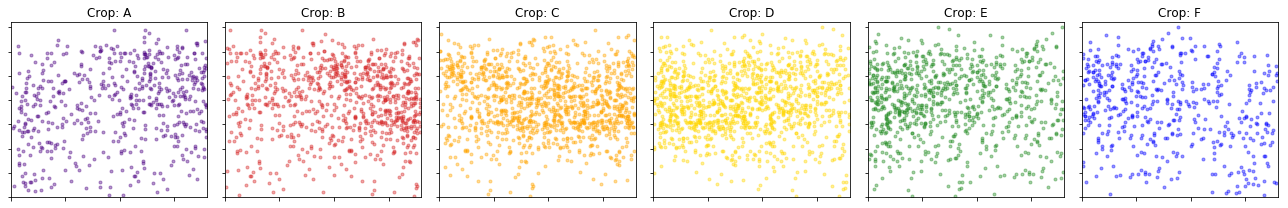

In [32]:
fig = plt.figure(figsize = (18, 3))

colors_list = ['tab:red', 'orange', 'gold', 'forestgreen', 'blue', 'indigo']

for crop_id, crop_name in enumerate(['A', 'B', 'C', 'D', 'E', 'F']):
    ax = fig.add_subplot(1, 6, crop_id+1)
    x = df_incrop['xpt_minus_xleft'].loc[df_incrop['crop_num'] == crop_name]
    y = df_incrop['ybottom_minus_ypt'].loc[df_incrop['crop_num'] == crop_name]
    ax.plot(x, y, marker = '.', ls = 'none', alpha = 0.4, color = colors_list[int(crop_id -1)])
    #ax.plot(x, y, marker = '.', ls = 'none', alpha = 0.4)
    plt.ylim(0, 180)
    plt.xlim(0, 180)
    plt.title(f'Crop: {crop_name}')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.tight_layout()



In [ ]:
fig = plt.figure(figsize = (12, 3))

colors_list = ['tab:red', 'orange', 'gold', 'forestgreen']

for crop_id in range(1, 5):
    ax = fig.add_subplot(1, 4, crop_id)
    x = df_incrop['xpt_minus_xleft'].loc[df_incrop['crop_number'] == crop_id]
    y = df_incrop['ybottom_minus_ypt'].loc[df_incrop['crop_number'] == crop_id]
    ax.plot(x, y, marker = '.', ls = 'none', alpha = 0.4, color = colors_list[int(crop_id -1)])
    #ax.plot(x, y, marker = '.', ls = 'none', alpha = 0.4)
    plt.ylim(0, 220)
    plt.xlim(0, 220)
    plt.title(f'Crop: {crop_id}')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.tight_layout()

fig2 = plt.figure(figsize = (12, 4))

# colors_list = ['forestgreen', 'indigo', 'mediumblue', 'gold', 'tab:red']
colors_list = ['blue', 'indigo', 'fuchsia']

for crop_id in range(5, 8):
    plot_num = crop_id - 4
    ax2 = fig2.add_subplot(1, 3, plot_num)
    x = df_incrop['xpt_minus_xleft'].loc[df_incrop['crop_number'] == crop_id]
    y = df_incrop['ybottom_minus_ypt'].loc[df_incrop['crop_number'] == crop_id]
    ax2.plot(x, y, marker = '.', ls = 'none', alpha = 0.4, color = colors_list[int(plot_num - 1)])
    #ax.plot(x, y, marker = '.', ls = 'none', alpha = 0.4)
    plt.ylim(0, 300)
    plt.xlim(0, 300)
    plt.title(f'Crop: {crop_id}')
    ax2.set_yticklabels([])
    ax2.set_xticklabels([])
    plt.tight_layout()